In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from ssim import *
import torch
import torch.fft as fft

device = 'cuda:2'

/home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [450]:
def add_rician_fading(data, transmit_power, distance=10, path_loss=2, snr_dB=10, k_std=0.1,Rayleigh_h_std=0.1):
    # data: 输入数据，形状 [1, 512]
    # transmit_power: 发射功率
    # distance: 传输距离
    # snr_dB: 信噪比（dB）
    # interference_power: 干扰功率

    # Set the device for the data tensor
    data = data.to(device)

    # 计算信号功率
    signal_power = transmit_power / (distance ** path_loss)

    # 计算噪声功率
    snr_linear = 10 ** (snr_dB / 10.0)
    noise_power =  signal_power/ (snr_linear) 


    # 生成干扰功率噪声（复数频域信号）
    complex_noise = torch.randn_like(data) * torch.sqrt(noise_power ) * 0.01   #生成干扰功率生成的噪声
    
    # 生成瑞利信道（复数频域信号）      使用random_tensor 简化瑞利信道影响
    #h_real = torch.randn_like(data)*0.1
    #h_imag = torch.randn_like(data)*0.1
    #rician_channel = h_real + 1j * h_imag
    random_tensor = torch.normal(mean=1, std=Rayleigh_h_std, size=data.size()).to(device)
    
    
    # 进行 FFT 变换
    fft_data = fft.fft(data)

    # 将噪声添加到频域信号中
    fft_data_with_noise = fft_data + complex_noise

    # 将瑞利信道应用于信号
    fft_data_with_fading = fft_data_with_noise * random_tensor

    # 计算加性高斯噪声的额外功率
    Gaussian_noise = torch.normal(mean=0, std=k_std, size=fft_data_with_fading.size()).to(device)

    # 将瑞利信道应用于信号叫噪声
    fft_data_with_fading = fft_data_with_noise * random_tensor+Gaussian_noise
  

    # 进行 IFFT 变换
    received_data = fft.ifft(fft_data_with_fading).real

    return received_data


In [46]:
# 示例使用,参数设置
data = torch.randn(1, 512).to(device)  # 生成随机数据，形状 [1, 512]，设置设备
transmit_power = torch.tensor(1).to(device)   # 发射功率（示例值）
distance = torch.tensor(10).to(device)   # 传输距离（示例值）
path_loss = torch.tensor(2).to(device)   #lujingshunhao
snr_dB = torch.tensor(10).to(device)  # 设置信噪比为 10dB  #影响干扰功率
k_std = torch.tensor(0.1).to(device)  # 设置高斯噪声方差（示例值）
Rayleigh_h_std=torch.tensor(0.01).to(device)

# 模拟中小规模衰落信道传输

In [4]:
def rician_fading(data, transmit_power=1, distance=10, path_loss=2, k_std=0.1, interference_power=0 , h=0.001):
    # data: 输入数据，形状 [1, 512]
    # transmit_power: 发射功率
    # distance: 传输距离
    # interference_power: 干扰功率
    # h ：信道衰减
    # Set the device for the data tensor
    data = data.to(device)

    # 生成瑞利信道（复数频域信号）      使用random_tensor 简化瑞利信道影响

    Rayleigh_h_std=((h*(distance**path_loss))/(transmit_power*2)) + k_std + interference_power

    random_tensor = torch.normal(mean=1, std=Rayleigh_h_std, size=data.size()).to(device)
    
    
    # 进行 FFT 变换
    fft_data = fft.fft(data)

    # 将噪声添加到频域信号中
    fft_data_with_noise = fft_data

    # 将瑞利信道应用于信号
    fft_data_with_fading = fft_data * random_tensor

    # 计算加性高斯噪声的额外功率
    #Gaussian_noise = torch.normal(mean=0, std= k_std, size=fft_data_with_fading.size()).to(device)

    # 将瑞利信道应用于信号叫噪声
    #fft_data_with_fading = fft_data_with_noise * random_tensor+Gaussian_noise

    fft_data_with_fading = fft_data_with_noise * random_tensor
  

    # 进行 IFFT 变换
    received_data = fft.ifft(fft_data_with_fading).real

    return received_data



In [3]:
conf =ffhq128_autoenc_72M()
#conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 122.59 M


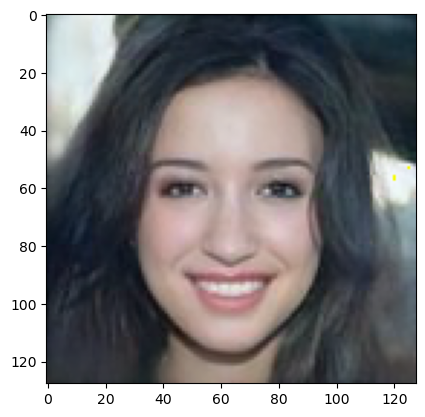

In [5]:
data = ImageDataset('imgs_align_ood', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(data)
batch = data[0]['img'][None]   #2

import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [6]:
cond = model.encode(batch.to(device))
print(cond.shape)
xT = model.encode_stochastic(batch.to(device), cond, T=20)
print(xT.shape)
print("Encoder success")   ###############完成encoder

#1111有用
# xT=rician_fading(xT, transmit_power=10, distance=10, path_loss=2, k_std=0.00001, interference_power=0.0001 , h=0.002)
# cond=rician_fading(cond, transmit_power=10, distance=10, path_loss=2, k_std=0.00001, interference_power= 0.0001, h=0.002)

#xT =add_rician_fading(xT, transmit_power, distance, path_loss,k_std, Rayleigh_h_std)     
#cond =add_rician_fading(cond, transmit_power, distance,path_loss, k_std, Rayleigh_h_std)
print("transmission success")



torch.Size([1, 512])
torch.Size([1, 3, 128, 128])
Encoder success
transmission success


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


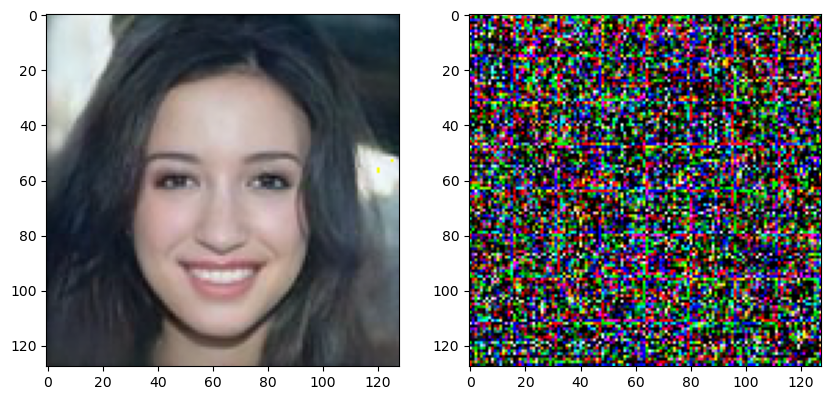

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

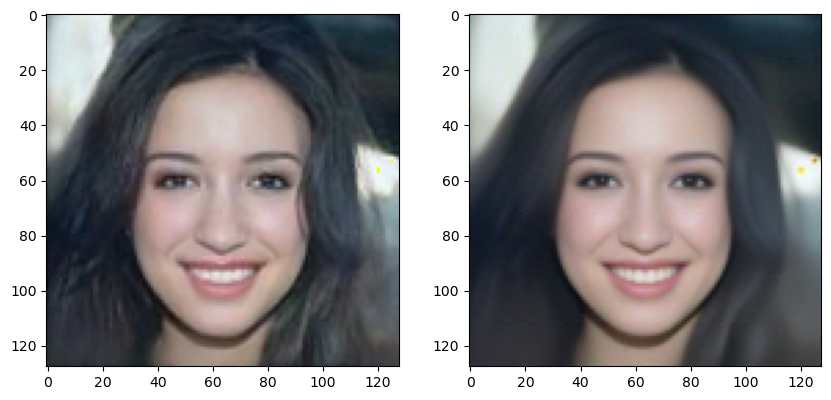

In [189]:

xT = F.interpolate(xT, size=[128,128], mode='bicubic', align_corners=False) 
scale_factor = 1.0
random_image = torch.randn_like(xT)*scale_factor
random_cond  = torch.randn_like(cond)               
pred = model.render(xT , cond, T=20)   #XT
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())

#random_tensor = torch.normal(mean=1, std=0.01, size=pred.size()).to(device)
#pred[0]=pred*random_tensor
ax[1].imshow(pred[0].permute(1, 2, 0).cpu()) 




ssim= tensor(0.8589)


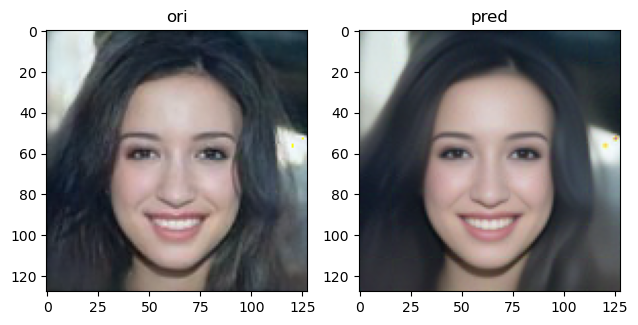

In [191]:
import matplotlib.pyplot as plt # plt 用于显示图片
from PIL import Image


img1 = ori[0].cpu()      #[3,128,128]
img2 = pred[0].cpu()     #[3,128,128]

ssim_score=ssim(img1,img2)
print('ssim=',ssim_score)


img1 = ori[0].permute(1, 2, 0).cpu()
img2 = pred[0].permute(1, 2, 0).cpu()

#结果展示

plt.subplot(121)
plt.imshow(img1)
plt.title('ori')
#不显示坐标轴
#plt.axis('off')

#子图2
plt.subplot(122)
plt.imshow(img2)
plt.title('pred')
#plt.axis('off')

# #设置子图默认的间距
plt.tight_layout()
#显示图像
plt.show()



In [43]:
#下面是使用数据适应后的实验

In [19]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(data)
batch1 = data[0]['img'][None]     #0

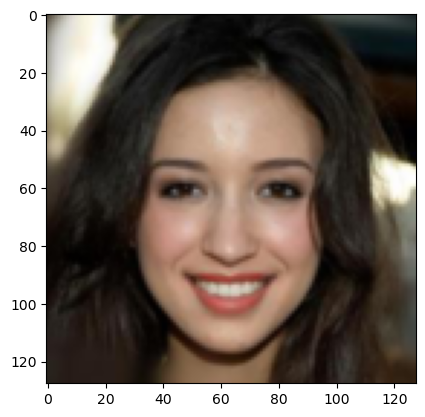

In [20]:
import matplotlib.pyplot as plt
plt.imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)              #下图输出的是原图

ssim= tensor(0.6617)


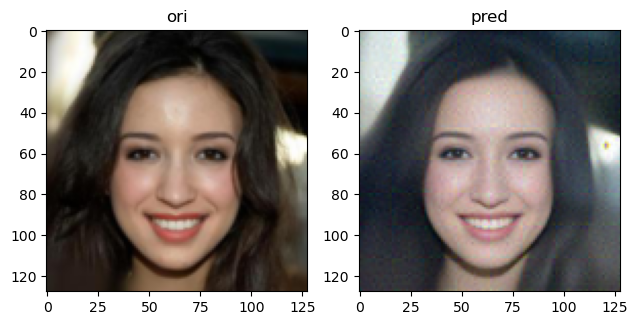

In [21]:
ori1 = (batch1 + 1) / 2   #batch1 是原图
img1 = ori1[0].cpu()      #[3,128,128]
img2 = pred[0].cpu()     #[3,128,128]

ssim_score=ssim(img1,img2)
print('ssim=',ssim_score)


img1 = ori1[0].permute(1, 2, 0).cpu()
img2 = pred[0].permute(1, 2, 0).cpu()

#结果展示

plt.subplot(121)
plt.imshow(img1)
plt.title('ori')
#不显示坐标轴
#plt.axis('off')

#子图2
plt.subplot(122)
plt.imshow(img2)
plt.title('pred')
#plt.axis('off')

# #设置子图默认的间距
plt.tight_layout()
#显示图像
plt.show()

In [105]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

img1_np = img1.cpu().numpy()
img2_np = img2.cpu().numpy()

# 使用 skimage 库计算 PSNR
psnr_value = peak_signal_noise_ratio(img1_np, img2_np)
print(f"PSNR值: {psnr_value} dB")

PSNR值: 24.485028608500418 dB


In [36]:
import torch
import lpips
from PIL import Image

#计算lpips 指标  越低越好

# 加载预训练的LPIPS模型
lpips_model = lpips.LPIPS(net="alex")

# 将图像转换为PyTorch的Tensor格式
image1_tensor = torch.tensor(np.array(img1_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
print(image1_tensor.size())
image2_tensor = torch.tensor(np.array(img2_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

# 使用LPIPS模型计算距离
distance = lpips_model(image1_tensor, image2_tensor)

print("LPIPS distance:", distance.item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 128, 128])
LPIPS distance: 6.608112926187459e-06
